In [1]:
import os
import math
import torch
from torch import nn
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets.mnist import MNIST


np.random.seed(47)
torch.manual_seed(47)

In [2]:
# defining all constants
BATCH_SIZE = 128
N_EPOCHS = 5
LR = 0.005
CRITERION = nn.CrossEntropyLoss()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# defining all transforms over here
tensor_transform = transforms.ToTensor()

In [4]:
download = True if not os.path.exists('./dataset') else False

train_set = MNIST(
    root='./dataset',
    train=True,
    download=download,
    transform=tensor_transform,
)

test_set = MNIST(
    root='./dataset',
    train=False,
    download=download,
    transform=tensor_transform,
)

print(len(train_set), len(test_set))

100%|██████████| 9912422/9912422 [00:00<00:00, 229512394.53it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 29792349.69it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155190095.07it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6860111.19it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

60000 10000


In [5]:
def show_examples(tensors, num_examples=BATCH_SIZE):
    row_cnt = int(math.sqrt(num_examples))
    image_data = tensors.detach().cpu()
    image_grid = make_grid(image_data, nrow=row_cnt).permute(1, 2, 0)
    plt.imshow(image_grid.clip(min=0, max=1))
    plt.axis("off")
    plt.show()

In [6]:
image, label = train_set[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 5


torch.Size([128, 1, 28, 28]) torch.Size([128])


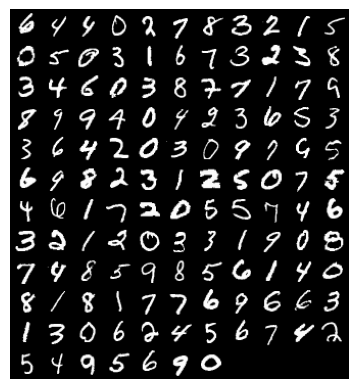

In [7]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)
show_examples(images)

In [8]:
def patchify(images, n_patches):
    n, c, h, w = images.shape
    assert h == w
    patches = torch.zeros(n, n_patches ** 2, h*w*c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in tqdm(enumerate(images)):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                patches[idx, i*n_patches + j] = patch.flatten()
    return patches

In [9]:
def get_positional_encodings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j/d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j-1) / d)))
    return result

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_d, n_heads=2):
        super(MultiHeadSelfAttention, self).__init__()
        self.d = hidden_d
        self.n_heads = n_heads
        assert self.d % self.n_heads == 0, f"can't divide dimension {d} into {n_heads} heads"
        self.d_head = int(self.d / self.n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(self.d_head, self.d_head) for _ in range(self.n_heads)])
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                seq = sequence[:, head * self.d_head: (head+1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)
                attention = self.softmax((q @ k.T) / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(res, dim=0) for res in result])


In [11]:
class VisionTransformerBlock(nn.Module):
    def __init__(self, n_heads, hidden_d, mlp_ratio=4):
        super(VisionTransformerBlock, self).__init__()
        self.n_heads = n_heads
        self.d = hidden_d
        self.mlp_ratio = mlp_ratio
        self.norm_1 = nn.LayerNorm(self.d)
        self.msa = MultiHeadSelfAttention(self.d, self.n_heads)
        self.norm_2 = nn.LayerNorm(self.d)
        self.mlp = nn.Sequential(
            nn.Linear(self.d, self.d * self.mlp_ratio),
            nn.GELU(),
            nn.Linear(self.d * self.mlp_ratio, self.d),
        )

    def forward(self, x):
        out = x + self.msa(self.norm_1(x))
        return out + self.mlp(self.norm_2(out))


In [12]:
class VisionTransformerModel(nn.Module):
    def __init__(
        self,
        input_shape=(1, 28, 28),
        n_patches=7,
        n_blocks=2,
        hidden_d=8,
        n_heads=2,
        out_d=10
    ):
        super(VisionTransformerModel, self).__init__()
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.hidden_d = hidden_d
        self.n_blocks = n_blocks
        self.out_d = out_d
        self.n_heads = n_heads

        assert self.input_shape[1] % self.n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert self.input_shape[2] % self.n_patches == 0, "Input shape not entirely divisible by number of patches"

        self.patch_size = (self.input_shape[1] // self.n_patches, self.input_shape[2] // self.n_patches)
        self.input_d = int(self.input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        self.register_buffer('positional_encodings', get_positional_encodings(self.n_patches ** 2 + 1, self.hidden_d), persistent=False)
        self.blocks = nn.ModuleList([VisionTransformerBlock(self.n_heads, self.hidden_d) for _ in range(self.n_blocks)])
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, self.out_d),
            nn.Softmax(dim=-1),
        )

    def forward(self, images):
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(DEVICE)
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.positional_encodings.repeat(n, 1, 1)
        for block in self.blocks:
            out = block(out)
        out = out[:, 0]
        out = self.mlp(out)
        return out

In [13]:
temp_model = VisionTransformerModel().to(DEVICE)
random_test_data = torch.randn((10, 1, 28, 28)).to(DEVICE)
output = temp_model(random_test_data)
output.shape, output

10it [00:00, 256.98it/s]


(torch.Size([10, 10]),
 tensor([[0.0677, 0.0752, 0.3834, 0.0473, 0.0209, 0.0454, 0.0766, 0.0513, 0.0683,
          0.1640],
         [0.0687, 0.0802, 0.3745, 0.0499, 0.0220, 0.0480, 0.0754, 0.0487, 0.0663,
          0.1663],
         [0.0717, 0.0781, 0.3648, 0.0525, 0.0230, 0.0497, 0.0745, 0.0506, 0.0678,
          0.1673],
         [0.0676, 0.0838, 0.3748, 0.0550, 0.0243, 0.0510, 0.0805, 0.0501, 0.0660,
          0.1469],
         [0.0736, 0.0791, 0.3605, 0.0510, 0.0222, 0.0508, 0.0702, 0.0465, 0.0682,
          0.1781],
         [0.0684, 0.0868, 0.3815, 0.0532, 0.0219, 0.0465, 0.0761, 0.0472, 0.0612,
          0.1573],
         [0.0713, 0.0759, 0.3646, 0.0497, 0.0228, 0.0509, 0.0731, 0.0497, 0.0717,
          0.1702],
         [0.0678, 0.0807, 0.3912, 0.0486, 0.0201, 0.0441, 0.0736, 0.0477, 0.0630,
          0.1631],
         [0.0717, 0.0762, 0.3679, 0.0482, 0.0213, 0.0470, 0.0727, 0.0493, 0.0694,
          0.1763],
         [0.0711, 0.0784, 0.3716, 0.0517, 0.0225, 0.0477, 0.0753, 0.

In [14]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [15]:
model = VisionTransformerModel((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(N_EPOCHS):
    train_loss = 0.0
    model.train()
    for batch, targets in tqdm(train_loader, desc=f'epoch: {epoch+1}'):
        batch = batch.to(DEVICE)
        targets = targets.to(DEVICE)
        predicted_targets = model(batch)
        loss = CRITERION(predicted_targets, targets)
        train_loss += loss.detach().cpu().item() / len(train_loader)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'train loss: {train_loss:.4f}')

    model.eval()
    with torch.inference_mode():
        correct, total = 0, 0
        test_loss = 0.0
        for batch, targets in tqdm(test_loader, desc='inferencing....'):
            batch, targets = batch.to(DEVICE), targets.to(DEVICE)
            predicted_targets = model(batch)
            loss = CRITERION(predicted_targets, targets)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            correct += torch.sum(
                torch.argmax(predicted_targets, dim=1) == targets
            ).detach().cpu().item()
            total += len(batch)
        print(f'test loss: {test_loss:.4f}')
        print(f'test accuracy: {correct/total * 100:.4f}')

epoch: 1: 100%|██████████| 469/469 [05:15<00:00,  1.49it/s]


train loss: 2.1229


inferencing....: 100%|██████████| 79/79 [00:27<00:00,  2.86it/s]


test loss: 1.9693
test accuracy: 49.2700


epoch: 2: 100%|██████████| 469/469 [05:06<00:00,  1.53it/s]


train loss: 1.9020


inferencing....: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


test loss: 1.8552
test accuracy: 60.3200


epoch: 3: 100%|██████████| 469/469 [05:08<00:00,  1.52it/s]


train loss: 1.8192


inferencing....: 100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


test loss: 1.7998
test accuracy: 66.0500


epoch: 4: 100%|██████████| 469/469 [05:12<00:00,  1.50it/s]


train loss: 1.7982


inferencing....: 100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


test loss: 1.8167
test accuracy: 64.3400


epoch: 5: 100%|██████████| 469/469 [05:13<00:00,  1.49it/s]


train loss: 1.7851


inferencing....: 100%|██████████| 79/79 [00:27<00:00,  2.82it/s]

test loss: 1.7903
test accuracy: 66.9400


In [16]:
torch.save(model, 'vit_model.pt')